<a href="https://colab.research.google.com/github/nupursjsu/Deep-Learning/blob/master/Ungraded_Assignment3/LR_Using_NN_mindset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression using Neural Network mindset

## Importing libraries

In [0]:
#Importing necessary libraries
import numpy as np
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import matplotlib.pyplot as plt
%matplotlib inline

## Loading the cat/nocat train and test datasets

In [0]:
# Code to read data file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Getting train datset
link = 'https://drive.google.com/open?id=19gY-R95mw4WDcZ-v1pU9j__Nk-S5nz_Y'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

19gY-R95mw4WDcZ-v1pU9j__Nk-S5nz_Y


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('train_catvnoncat.h5')

In [0]:
#Getting train datset
link = 'https://drive.google.com/open?id=1HRwtrqvstIqIgBMGgt6T43ddTGZss6YI'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1HRwtrqvstIqIgBMGgt6T43ddTGZss6YI


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('test_catvnoncat.h5')

In [0]:
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [0]:
# Loading the cat/nocat train and test dataset and their classes
train_img_x, train_img_y, test_img_x, test_img_y, classes = load_dataset()

label = [1], it's a 'cat' picture.


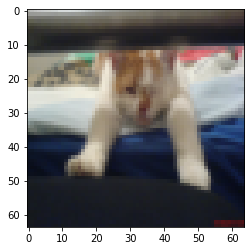

In [0]:
# Displaying a picture from dataset
idx = 29
plt.imshow(train_img_x[idx])
print ("label = " + str(train_img_y[:, idx]) + ", it's a '" + classes[np.squeeze(train_img_y[:, idx])].decode("utf-8") +  "' picture.")

In [0]:
#Displaying the number of training examples in train and test dataset and the shape of datasets
train = train_img_x.shape[0]
test = test_img_x.shape[0]
num_px = train_img_x.shape[2]


print ("Number of training examples: train = " + str(train))
print ("Number of testing examples: test = " + str(test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_img_x shape: " + str(train_img_x.shape))
print ("train_img_y shape: " + str(train_img_y.shape))
print ("test_img_x shape: " + str(test_img_x.shape))
print ("test_img_y shape: " + str(test_img_y.shape))

Number of training examples: train = 209
Number of testing examples: test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_img_x shape: (209, 64, 64, 3)
train_img_y shape: (1, 209)
test_img_x shape: (50, 64, 64, 3)
test_img_y shape: (1, 50)


## Preprocessing data

In [0]:
# Reshape the training and test images
train_img_x_flatten = train_img_x.reshape(train_img_x.shape[0], -1).T
test_img_x_flatten = test_img_x.reshape(test_img_x.shape[0], -1).T

print ("train_img_x_flatten shape: " + str(train_img_x_flatten.shape))
print ("train_img_y shape: " + str(train_img_y.shape))
print ("test_img_x_flatten shape: " + str(test_img_x_flatten.shape))
print ("test_img_y shape: " + str(test_img_y.shape))
print ("sanity check after reshaping: " + str(train_img_x_flatten[0:5,0]))

train_img_x_flatten shape: (12288, 209)
train_img_y shape: (1, 209)
test_img_x_flatten shape: (12288, 50)
test_img_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [0]:
#Normalizing the image data
train_img_x = train_img_x_flatten/255.
test_img_x = test_img_x_flatten/255.

## Building our own Neural Network Model

In [0]:
#Implementing sigmoid function
def basic_sigmoidFun(n):
    res = 1/(1 + np.exp(-n)) 
    return res

In [0]:
#Initializing the parameters with zeroes
def initialize_params(dim):
    w = np.zeros(shape=(dim, 1), dtype=np.float32)
    bs = 0
    assert(w.shape == (dim, 1))
    assert(isinstance(bs, float) or isinstance(bs, int))
    return w, bs

In [0]:
#Forward and Backward propogation
def prop(w, bs, X, Y):
    r = X.shape[1]
    
    # FORWARD PROPAGATION
    # computing activation
    A = basic_sigmoidFun(np.dot(w.T, X) + bs) 
    # computing loss   
    loss = (-1. / r) * np.sum((Y*np.log(A) + (1 - Y)*np.log(1-A)), axis=1)     
    
    # BACKWARD PROPAGATION
    dw = (1./r)*np.dot(X,((A-Y).T))
    db = (1./r)*np.sum(A-Y, axis=1)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    loss = np.squeeze(loss)
    assert(loss.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, loss

In [0]:
#Function to update parameters using gradient descent
def optimize_fun(w, bs, X, Y, no_of_iterations, learning_rate, print_cost = False):
    losses = []
    
    for i in range(no_of_iterations):
        
        
        # Calculating loss and gradient
        grads, loss = prop(w=w, bs=bs, X=X, Y=Y)
        
        # Retrieving gradients from grads
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate*dw
        bs = bs -  learning_rate*db
        
        # Record the losses
        if i % 100 == 0:
            losses.append(loss)
        
        # Printing the loss after every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Loss after iteration %i: %f" %(i, loss))
    
    params = {"w": w,
              "bs": bs}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, losses

In [0]:
#Implementing prediction function
def predict_fun(w, bs, X):
    r = X.shape[1]
    Y_pred = np.zeros((1,r))
    w = w.reshape(X.shape[0], 1)
    
    # Computing vector "A" denoting the probabilities if a cat is there in the picture
    A = basic_sigmoidFun(np.dot(w.T, X) + bs)
    
    [print(x) for x in A]
    for i in range(A.shape[1]):
        
        # Converting probabilities to actual predictions
        if A[0, i] >= 0.5:
            Y_pred[0, i] = 1
            
        else:
            Y_pred[0, i] = 0

    assert(Y_pred.shape == (1, r))
    
    return Y_pred

In [0]:
#Defining the final model
def my_NNmodel(X_train, Y_train, X_test, Y_test, no_of_iterations = 2000, learning_rate = 0.5, print_cost = False):
    #Initializing params
    w, bs = initialize_params(X_train.shape[0])
    #Computing gradient descent
    params, grads, losses = optimize_fun(w, bs, X_train, Y_train, no_of_iterations, learning_rate, print_cost)
    
    #Getting params w and bs from dictionary "params"
    w = params["w"]
    bs = params["bs"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_pred_test = predict_fun(w, bs, X_test)
    Y_pred_train = predict_fun(w, bs, X_train)


    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_pred_test - Y_test)) * 100))

    
    res = {"losses": losses,
         "Y_pred_test": Y_pred_test, 
         "Y_pred_train" : Y_pred_train, 
         "w" : w, 
         "bs" : bs,
         "learning_rate" : learning_rate,
         "no_of_iterations": no_of_iterations}
    
    return res

In [0]:
res = my_NNmodel(train_img_x, train_img_y, test_img_x, test_img_y, no_of_iterations = 1000, learning_rate = 0.005, print_cost = True)

Loss after iteration 0: 0.693147
Loss after iteration 100: 0.584508
Loss after iteration 200: 0.466949
Loss after iteration 300: 0.376007
Loss after iteration 400: 0.331463
Loss after iteration 500: 0.303273
Loss after iteration 600: 0.279880
Loss after iteration 700: 0.260042
Loss after iteration 800: 0.242941
Loss after iteration 900: 0.228004
[0.89441238 0.77967441 0.84549834 0.86653308 0.66810834 0.50044225
 0.08139283 0.82831715 0.84971405 0.64878079 0.34433766 0.48043143
 0.72508056 0.68664053 0.02530106 0.86325039 0.04549498 0.75613059
 0.25608797 0.07818485 0.8452877  0.11604584 0.03432353 0.65652069
 0.643007   0.6427052  0.62292581 0.03556986 0.07988722 0.98921574
 0.32785021 0.71903522 0.69472183 0.42315036 0.65476861 0.06372343
 0.13740218 0.73538971 0.41707558 0.09624695 0.62186598 0.50690832
 0.6046851  0.06431431 0.86622838 0.31783254 0.31065323 0.94817385
 0.58352308 0.13513304]
[0.25339524 0.13610927 0.80691918 0.00098162 0.07859124 0.18282667
 0.06381336 0.87625992 0.

y = 1, you predicted that it is a "cat" picture.


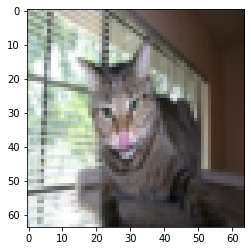

In [0]:
#Displaying a correctly classified image
idx = 20
plt.imshow(test_img_x[:,idx].reshape((num_px, num_px, 3)))
print ("y = " + str(test_img_y[0,idx]) + ", you predicted that it is a \"" + classes[int(res["Y_pred_test"][0,idx])].decode("utf-8") +  "\" picture.")

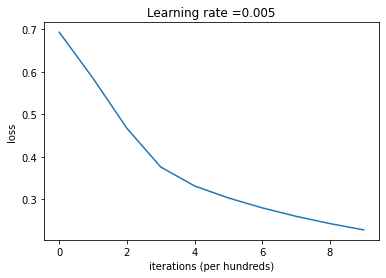

In [0]:
#Plotting loss function and gradients
losses = np.squeeze(res['losses'])
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(res["learning_rate"]))
plt.show()